In [290]:
import copy
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tool.file_and_directory_management import read_json

os.chdir('..')

In [184]:
annotated_files_path = 'experiments\\polish\\coreference'
gold_standard_annotations_path = 'data\\testing_sets\\test_coreference_gold_standard'
titles = ['Ksiega_dzungli', 'Hrabia_Monte_Christo']

In [291]:
def select_fragment_by_id(fragments, id):
    for fragment in fragments:
        if fragment['id'] == id:
            return fragment
    return None


def reformat_label_studio_annotations(fragments):
    reformatted_annotations = []
    for j in range(len(fragments)):
        fragment = select_fragment_by_id(fragments, j + 1)
        annotations = fragment['annotations'][0]['result']
        new_annotations = []
        skip_loop = False
        for i in range(len(annotations)):
            if skip_loop:
                skip_loop = False
                continue

            if i+1 >= len(annotations) or annotations[i]['id'] != annotations[i + 1]['id']:
                choice = 'PERSON'
                skip_loop = False
            else:
                choice = annotations[i + 1]['value']['choices'][0]
                skip_loop = True
            annotation = {'text': annotations[i]['value']['text'], 'start': annotations[i]['value']['start'],
                            'end': annotations[i]['value']['end'], 'part_of_speech': annotations[i]['value']['labels'][0], 'label': choice}
            new_annotations.append(annotation)

        reformatted_annotations.append(new_annotations)
    return reformatted_annotations


def fragments_annotations_to_novel_annotations_df(fragments):
    annotation_list = copy.deepcopy(fragments[0])
    for fragment in fragments[1:]:
        annotation_list += copy.deepcopy(fragment)
    return pd.DataFrame(annotation_list)

In [265]:
def plot_hist_parts_of_speech(annotations_df, text):
    sns.histplot(x='part_of_speech', data=annotations_df)
    plt.title(f'Part of speech distribution for {text}')
    plt.xlabel('Part of speech')
    plt.show()

def plot_hist_labels(annotations_df, text):

    sns.histplot(y='label', data=annotations_df)
    plt.title(f'Label\'s distribution for {text}')
    plt.show()

In [179]:
def find_correctly_labeled(label_studio_annotations, model_annotations):
    assert type(label_studio_annotations) is pd.DataFrame and type(model_annotations) is pd.DataFrame
    labeled_correctly = pd.merge(label_studio_annotations, model_annotations, how='inner', on=['start', 'end', 'text', 'label'])
    labeled_correctly = labeled_correctly.drop(columns=['start', 'end'])
    return labeled_correctly


def find_correctly_detected_corefs(label_studio_annotations, model_annotations):
    assert type(label_studio_annotations) is pd.DataFrame and type(model_annotations) is pd.DataFrame
    correctly_detected_corefs = pd.merge(label_studio_annotations, model_annotations, how='inner', on=['start', 'end', 'text'])
    correctly_detected_corefs = correctly_detected_corefs.drop(columns=['start', 'end'])
    return correctly_detected_corefs

## 0. Prepare data

In [294]:
novels_annotations = {}
for title in titles:
    fragments = read_json(os.path.join(gold_standard_annotations_path, f'{title}.json'))
    reformatted_annotations = reformat_label_studio_annotations(fragments)
    model_annotations = read_json(os.path.join(annotated_files_path, f'{title}.json'))
    novels_annotations[title] = {'gold_standard_annotations': reformatted_annotations,
    'model_annotations': [ma['annotations'] for ma in model_annotations]}

## 1. General statistics for gold standard annotations

### 1.1. Hrabia Monte Christo

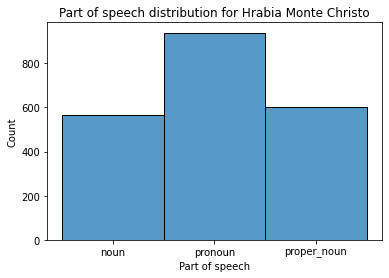

In [266]:
title = 'Hrabia_Monte_Christo'
data = fragments_annotations_to_novel_annotations_df(novels_annotations[title]['gold_standard_annotations'])
plot_hist_parts_of_speech(data, text=f'{title.replace("_", " ")}')

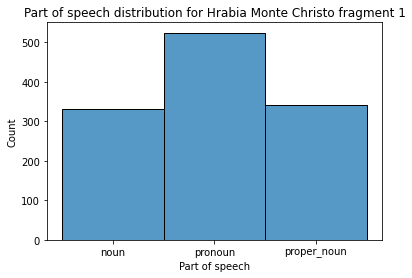

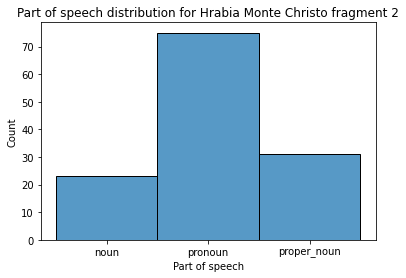

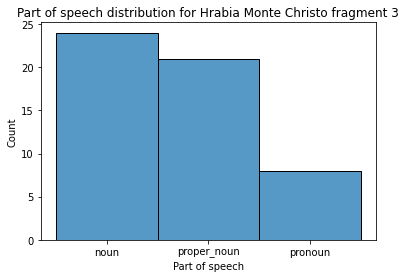

In [252]:
for i, annotated_fragment in enumerate(novels_annotations[title]['gold_standard_annotations']):
    plot_hist_parts_of_speech(pd.DataFrame(annotated_fragment), text=f'{title.replace("_", " ")} fragment {i + 1}')

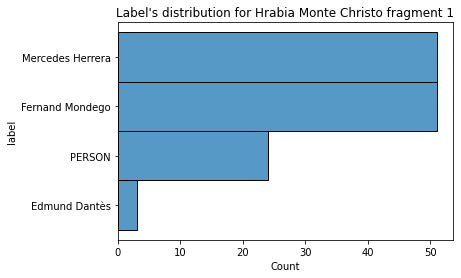

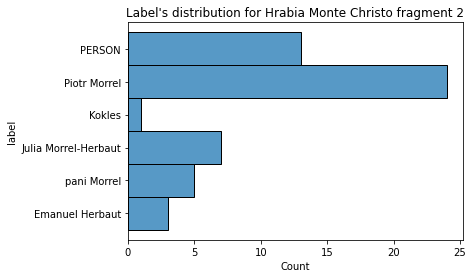

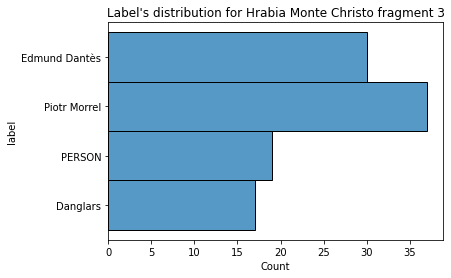

In [120]:
for i, annotated_fragment in enumerate(novels_annotations[title]['gold_standard_annotations']):
    plot_hist_labels(pd.DataFrame(annotated_fragment), text=f'{title.replace("_", " ")} fragment {i + 1}')

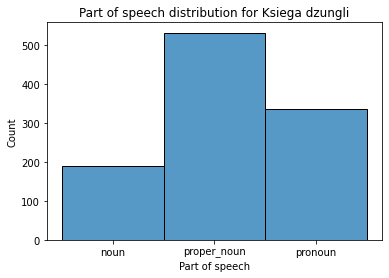

In [253]:
title = 'Ksiega_dzungli'
data = fragments_annotations_to_novel_annotations_df(novels_annotations[title]['gold_standard_annotations'])
plot_hist_parts_of_speech(data, text=f'{title.replace("_", " ")}')

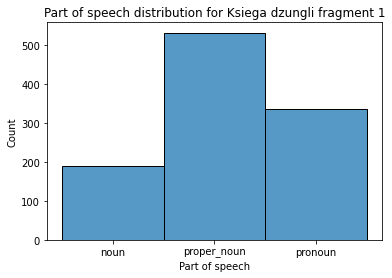

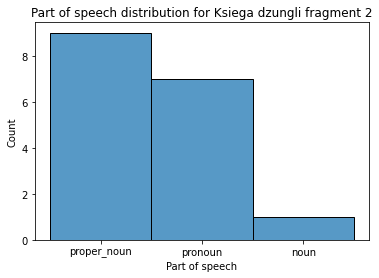

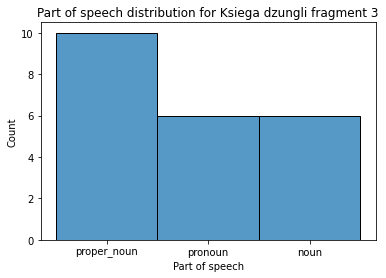

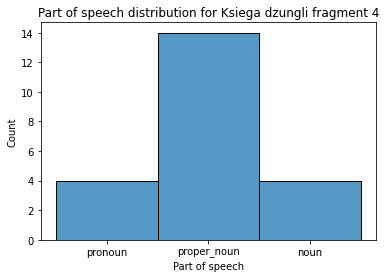

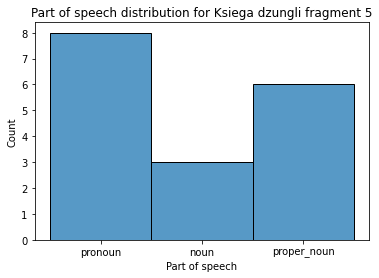

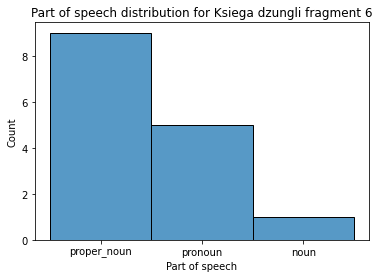

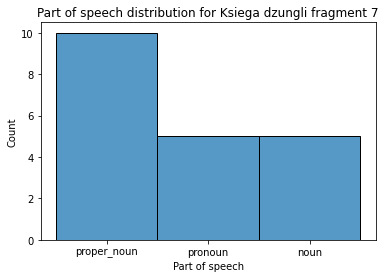

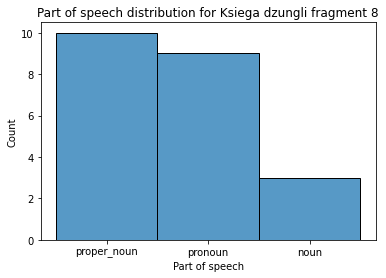

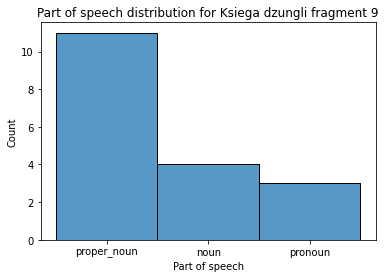

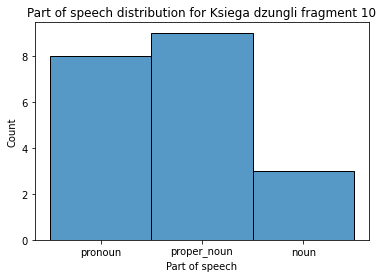

In [254]:
for i, annotated_fragment in enumerate(novels_annotations[title]['gold_standard_annotations']):
    plot_hist_parts_of_speech(pd.DataFrame(annotated_fragment), text=f'{title.replace("_", " ")} fragment {i + 1}')

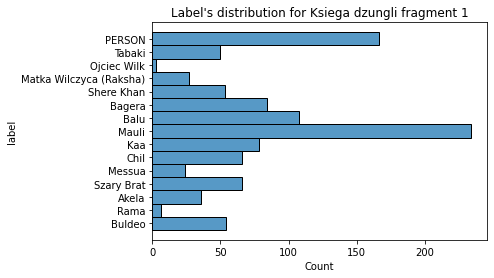

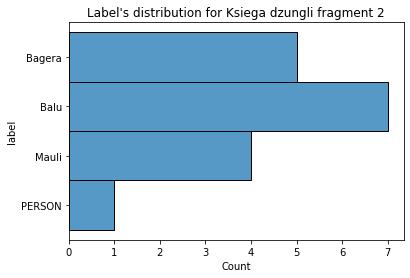

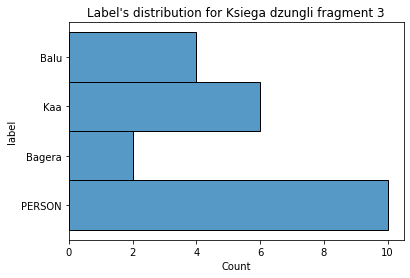

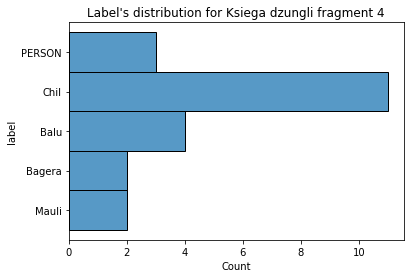

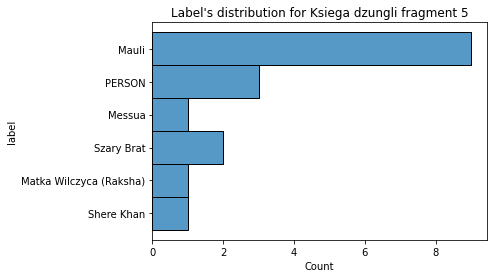

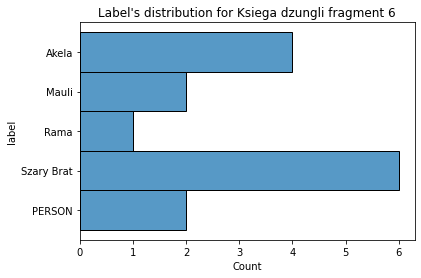

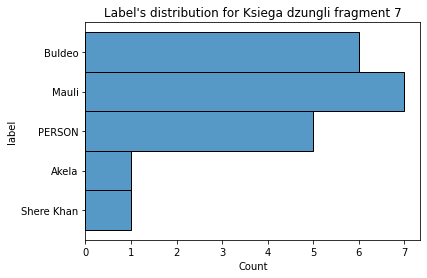

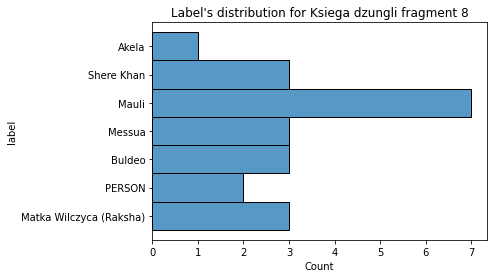

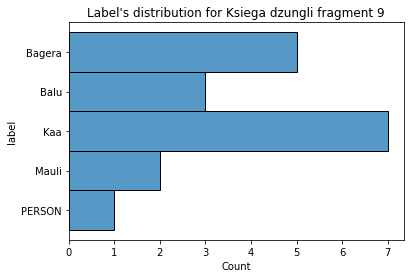

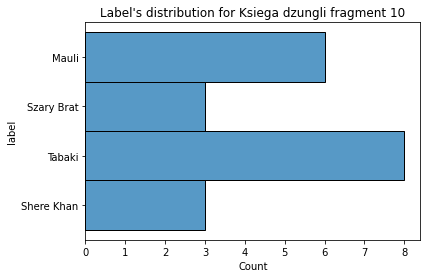

In [255]:
for i, annotated_fragment in enumerate(novels_annotations[title]['gold_standard_annotations']):
    plot_hist_labels(pd.DataFrame(annotated_fragment), text=f'{title.replace("_", " ")} fragment {i + 1}')

## 2. Evaluation of annotations

### 2.1. General statistics

In [198]:
def count_annotations(fragments):
    count = 0
    for fragment in fragments:
        count += len(fragment)
    return count

In [213]:
correctly_labeled = {}
correctly_detected_corefs = {}
for title in titles:
    novel = novels_annotations[title]
    temp_correctly_labeled = pd.DataFrame({'text': [], 'part_of_speech': [], 'label': []})
    temp_correctly_detected_corefs = pd.DataFrame({'text': [], 'part_of_speech': [], 'label': []})
    for gold_anno, model_anno in zip(novel['gold_standard_annotations'], novel['model_annotations']):
        temp_correctly_labeled = pd.concat([temp_correctly_labeled, find_correctly_labeled(pd.DataFrame(gold_anno), pd.DataFrame(model_anno))]).reset_index(drop=True)
        temp_correctly_detected_corefs = pd.concat([temp_correctly_detected_corefs, find_correctly_detected_corefs(pd.DataFrame(gold_anno), pd.DataFrame(model_anno))]).reset_index(drop=True)
    correctly_labeled[title] = temp_correctly_labeled
    correctly_detected_corefs[title] = temp_correctly_detected_corefs

In [214]:
evaluation_df = pd.DataFrame(columns=['true annotations', 'model annotations', 'missing annotations', 'correctly annotated', 'annotations with wrong labels', 'completely wrong annotations'])

In [215]:
for title in titles:
    novel = novels_annotations[title]
    true_annotations = count_annotations(novel['gold_standard_annotations'])
    model_annotations = count_annotations(novel['model_annotations'])
    correctly_annotated = len(correctly_labeled[title])
    missing_annotations = true_annotations - len(correctly_detected_corefs[title])
    annotations_wrong_labels = len(correctly_detected_corefs[title]) - correctly_annotated
    completely_wrong_annotations = model_annotations - annotations_wrong_labels - correctly_annotated
    evaluation_df.loc[title] = [true_annotations, model_annotations, missing_annotations, correctly_annotated, annotations_wrong_labels, completely_wrong_annotations]
evaluation_df

,true annotations,model annotations,missing annotations,correctly annotated,annotations with wrong labels,completely wrong annotations
Ksiega_dzungli,190,164,136,41,13,110
Hrabia_Monte_Christo,285,285,166,72,47,166


### 2.2. Statistics with respect to parts of speech

In [295]:
part_of_speech_ratio = {}
for title in titles:
    novel = novels_annotations[title]
    counter = correctly_labeled[title].groupby('part_of_speech').size()
    denominator = fragments_annotations_to_novel_annotations_df(novel['gold_standard_annotations']).groupby('part_of_speech').size()
    part_of_speech_ratio[title] = (counter/denominator).reset_index().rename(columns={0: 'ratio'})

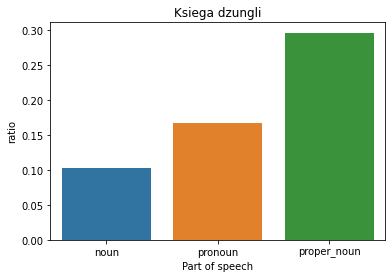

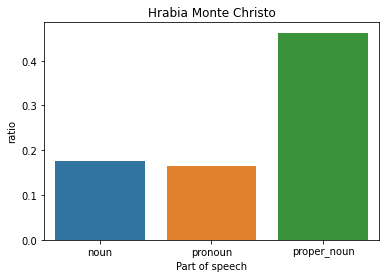

In [296]:
for title in titles:
    data = part_of_speech_ratio[title]
    sns.barplot(x='part_of_speech', y='ratio', data=data)
    plt.title(title.replace('_', ' '))
    plt.xlabel('Part of speech')
    plt.show()